In [1]:
import os
import sys
import random
from PIL import Image
import numpy as np
import pandas as pd
#for image transform
#import cv2

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = [5, 5]
matplotlib.rcParams['figure.dpi'] = 200

import random
import time


from auto_encoder_submission import *
from bbox import *
from model_loader import *
from test_nn_submission import *

In [2]:
model_loader = ModelLoader()

Loading musketeer.pt


In [3]:
from sklearn.metrics import confusion_matrix

def convert_800 (bbox):
    bbox = bbox.view(-1, 1, 8)
    bbox = bbox *10 +400
    
    road_img = torch.zeros(800, 800)
    for i in range(bbox.shape[0]):
        colmax = int(round(bbox[i][0][0].item()))
        colmin =  int(round(bbox[i][0][2].item()))
        rowmax =  int(round(bbox[i][0][4].item()))
        rowmin =  int(round(bbox[i][0][5].item()))
        
        road_img[rowmin:rowmax, colmin:colmax] = 1
    return road_img.numpy()
        
def cal_score(pred_conv, label_conv):
    
    #both pred_conv, label_conv are 800 x 800 of 0, 1 in each pixel
    #first convert label into 0, 1 into 10, 20's 
    #calculate label - pred
    #keys are TP = 19, FP = 9, TN = 10, FN = 20
    assert(pred_conv.shape == (800, 800))
    assert(label_conv.shape == (800, 800))
    label2 = (label_conv + 1) *10
    
    diff_M = (label2 - pred_conv)
    TP = np.sum(diff_M == 19) 
    FP = np.sum(diff_M == 9) 
    TN = np.sum(diff_M == 10) 
    FN = np.sum(diff_M == 20) 
    #print(TP)
    score = TP/(TP + FP + FN)
    return TP, FP, TN, FN, score
    
def gen_train_val_index(labeled_scene_index):
    breakpt = len(labeled_scene_index)//3
    labeled_scene_index_shuf = labeled_scene_index
    random.shuffle(labeled_scene_index_shuf)

    train_labeled_scene_index = labeled_scene_index_shuf[:-breakpt]
    val_labeled_scene_index = labeled_scene_index_shuf[-breakpt: ]
    return train_labeled_scene_index, val_labeled_scene_index 

In [4]:
np.random.seed(0)
torch.manual_seed(0);
image_folder = '../data'
annotation_csv = '../data/annotation.csv'

In [5]:
labeled_scene_index = np.arange(106, 134)
train_labeled_scene_index, val_labeled_scene_index  = gen_train_val_index(labeled_scene_index)

In [6]:
val_labeled_scene_index

array([133, 132, 121, 124, 122, 109, 118, 111, 117])

In [7]:
#make a simple validation loader
labeled_scene_index = np.array([107, 133])
#copied from run_test.py

labeled_trainset_task1 = LabeledDataset(
    image_folder=image_folder,
    annotation_file=annotation_csv,
    scene_index=val_labeled_scene_index,
    transform=get_transform_task1(),
    extra_info=False
    )
dataloader_task1 = torch.utils.data.DataLoader(
    labeled_trainset_task1,
    batch_size=1,
    shuffle=True,
    num_workers=4
    )

In [8]:
#check bouding box
TP_tot = 0
FP_tot = 0
TN_tot = 0
FN_tot = 0


with torch.no_grad():
    ts_list = []
    for i, data in enumerate(dataloader_task1):
       
        sample, target, road_image = data
        sample = sample.cuda()
        
        predicted_bounding_boxes = model_loader.get_bounding_boxes(sample)[0].cpu() #does this solve our problem of first element
        
        pred_conv = convert_800(predicted_bounding_boxes)
        label_conv = convert_800(target['bounding_box'][0])
        TP, FP, TN, FN, score = cal_score(pred_conv, label_conv)
        
        ts_list.append(score)
        TP_tot += TP
        FP_tot += FP
        TN_tot += TN
        FN_tot += FN
        
        #if i%20 ==0:
            #print(predicted_bounding_boxes.shape, target['bounding_box'][0].shape)
            #print(predicted_bounding_boxes.min(), predicted_bounding_boxes.max())

            #fig, axs = plt.subplots(1,2,figsize=(6, 3))
            #axs[0].imshow(pred_conv, cmap ='binary')

            #plot target
            #axs[1].imshow(label_conv, cmap ='binary')



In [9]:
print(np.array(ts_list).mean())

0.015304470439321169


In [10]:
precision = TP_tot/(TP_tot+FP_tot) #precision
precision

0.01847316440790856

In [11]:
recall = TP_tot/(TP_tot + FN_tot) #recall
recall

0.06920041784578566

In [12]:
F1_score = 2*(precision*recall)/(precision + recall)

In [13]:
F1_score

0.029161593791436607

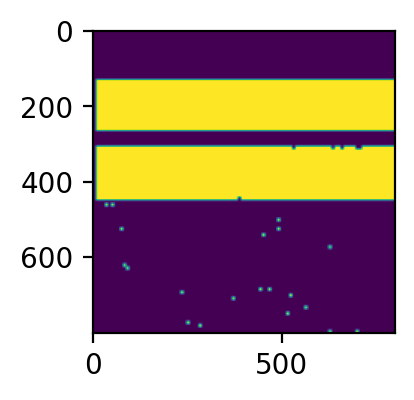

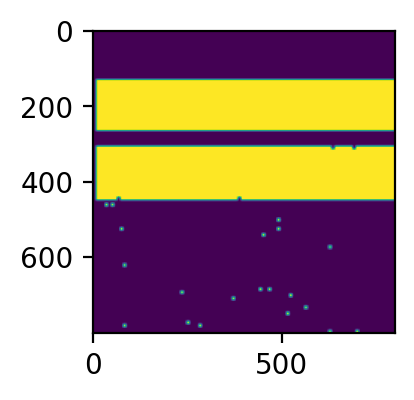

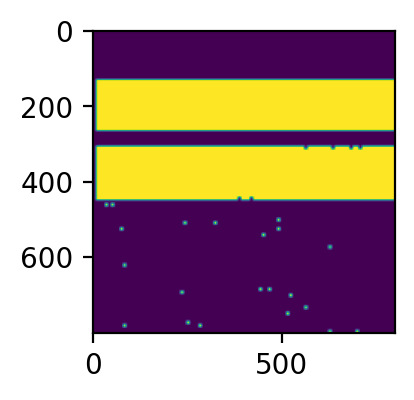

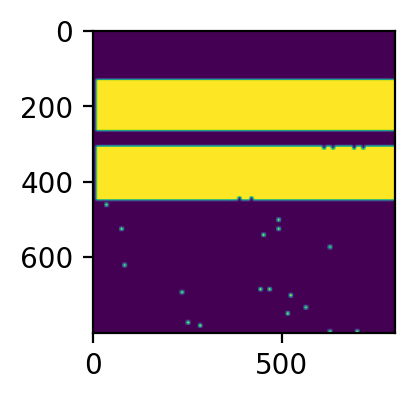

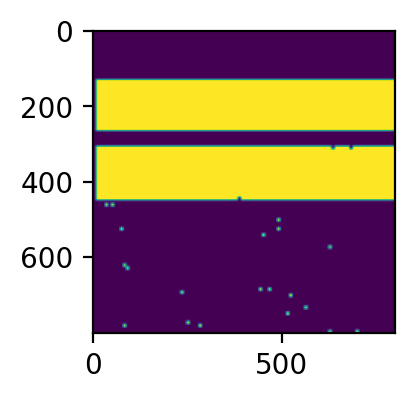

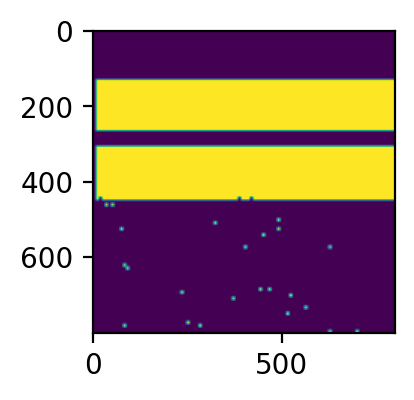

In [14]:
with torch.no_grad():
    for i, data in enumerate(dataloader_task1):
        
        sample, target, road_image = data
        sample = sample.cuda()
        
        predicted_road_map = model_loader.get_binary_road_map(sample).cpu()
        plt.figure(figsize=(2,2))
        plt.imshow(predicted_road_map[0].cpu().data.numpy())
        if i ==5:
            break

In [15]:
predicted_road_map.shape

torch.Size([1, 800, 800])

In [16]:
predicted_road_map.min()

tensor(0., dtype=torch.float64)

In [17]:
predicted_road_map.max()

tensor(1., dtype=torch.float64)